Loading the dataset


In [1]:
import pandas as pd
from sklearn.utils import shuffle

dataset = pd.read_csv('train.csv', encoding='ISO-8859-1', header= None)
dataset = dataset.rename(index=str, columns={ 0: "review", 1: "aspect_category", 2: "sentiment"})
dataset = shuffle(dataset)
dataset.head(5)

,review,aspect_category,sentiment
452,Safety team is a joke and gets people in troub...,leadership,Neutral
387,Depends on the site but my managers are great,leadership,Positive
242,though it depends heavily on team,leadership,Neutral
438,You should also stop gossiping about your team...,leadership,Negative
99,Culture of respect and transparency.,environment,Positive


Extract Aspect Terms Using spacy NLP library

In [2]:
import spacy
nlp = spacy.load('en')

dataset.review = dataset.review.str.lower()

aspect_terms = []
for review in nlp.pipe(dataset.review):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset['aspect_terms'] = aspect_terms
dataset.head(10)

,review,aspect_category,sentiment,aspect_terms
452,safety team is a joke and gets people in troub...,leadership,Neutral,team joke people trouble
387,depends on the site but my managers are great,leadership,Positive,site managers
242,though it depends heavily on team,leadership,Neutral,team
438,you should also stop gossiping about your team...,leadership,Negative,members
99,culture of respect and transparency.,environment,Positive,culture respect transparency
124,as long as you demand the best from yourself y...,environment,Positive,
80,great place to work.,environment,Positive,place
53,"food, cheap massages, great gyms, offsites, de...",environment,Positive,food massages gyms offsites
150,raises benefits and the people,environment,Positive,benefits people
236,everyone is really smart,leadership,Positive,everyone


Building the Aspect Categories Model using NN and Keras


In [3]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation


aspect_categories_model = Sequential()
aspect_categories_model.add(Dense(512, input_shape=(6000,), activation='relu'))
aspect_categories_model.add(Dense(3, activation='softmax'))
aspect_categories_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


Perform Bag of Words (BoW) Word Embedding to encode aspect terms as vectors in order to feed to CNN

In [4]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dataset.review)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(dataset.aspect_terms))

Encoding the aspect_category to dummy variable using Sklearn

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(dataset.aspect_category)
dummy_category = to_categorical(integer_category)
X_train, X_test, Y_train, Y_test = train_test_split(aspect_tokenized,dummy_category, test_size = 0.2, random_state = 42)

Fitting and Training the Model

In [6]:
batch_size = 32
history_aspect = aspect_categories_model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs = 10, batch_size=batch_size, verbose = 2)
#history_aspect=aspect_categories_model.fit(aspect_tokenized, dummy_category, epochs=10, verbose=1)

Train on 527 samples, validate on 132 samples
Epoch 1/10
 - 2s - loss: 1.0722 - acc: 0.5161 - val_loss: 1.0326 - val_acc: 0.6136
Epoch 2/10
 - 1s - loss: 0.9542 - acc: 0.7989 - val_loss: 0.9422 - val_acc: 0.6667
Epoch 3/10
 - 1s - loss: 0.8029 - acc: 0.8520 - val_loss: 0.8357 - val_acc: 0.6742
Epoch 4/10
 - 1s - loss: 0.6350 - acc: 0.8558 - val_loss: 0.7637 - val_acc: 0.6970
Epoch 5/10
 - 1s - loss: 0.5087 - acc: 0.8539 - val_loss: 0.7383 - val_acc: 0.6742
Epoch 6/10
 - 1s - loss: 0.4205 - acc: 0.8748 - val_loss: 0.7438 - val_acc: 0.6515
Epoch 7/10
 - 1s - loss: 0.3610 - acc: 0.8843 - val_loss: 0.7616 - val_acc: 0.6667
Epoch 8/10
 - 1s - loss: 0.3216 - acc: 0.8786 - val_loss: 0.7812 - val_acc: 0.6894
Epoch 9/10
 - 1s - loss: 0.2951 - acc: 0.8937 - val_loss: 0.8093 - val_acc: 0.6894
Epoch 10/10
 - 1s - loss: 0.2750 - acc: 0.8975 - val_loss: 0.8334 - val_acc: 0.6742


Visaulizing Training Accuracy and Loss

<Figure size 432x288 with 0 Axes>

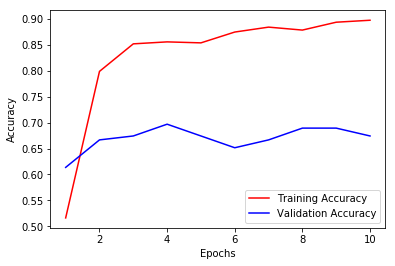

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history_aspect.history['acc']
val_acc = history_aspect.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color = 'red', label='Training acc')
plt.plot(epochs, val_acc, color = 'blue', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.figure()

In [26]:
import numpy as np 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_predict = aspect_categories_model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]

matrix = confusion_matrix(y_test_non_category, y_predict_non_category)
print(matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_non_category, y_predict_non_category)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_non_category, y_predict_non_category,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_non_category, y_predict_non_category,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_non_category, y_predict_non_category,average='macro')
print('F1 score: %f' % f1)

[[28  9  4]
 [10 38  3]
 [11  6 23]]
Accuracy: 0.674242
Precision: 0.685025
Recall: 0.667675
F1 score: 0.670045


Testing the model on a new review using the same pre-processing

In [27]:
new_review = "Good for learn new technologies "

chunks = [(chunk.root.text) for chunk in nlp(new_review).noun_chunks if chunk.root.pos_ == 'NOUN']
new_review_aspect_terms = ' '.join(chunks)
print(new_review_aspect_terms)
new_review_aspect_tokenized = tokenizer.texts_to_matrix([new_review_aspect_terms])

new_review_category = label_encoder.inverse_transform(aspect_categories_model.predict_classes(new_review_aspect_tokenized))
print(new_review_category)

technologies
['learning']
